In this notebook, we will perform random forest without SMOTE and assess how our model predict the target variables: validation scale (AR strength) and snow/no snow (precipitation type)

Takeaway:
1. The obtained accuracy score for AR strength and precipitation type are about 0.64 and 0.57 which are less than random forest with SMOTE
2. Tuning the hyperparameter (we used gridsearch) did not improve the accuracy at all for AR strength. There was small accuracy improvement for precipitation type. Possible reason: dataset is too small

Therefore, oversampling technique like SMOTE enhances model's performance

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [17]:
features = pd.read_csv('data\era5_matched_ar_events.csv', index_col=0) 
df = features.copy()
features.head()
print('The shape of our features is:', features.shape)

The shape of our features is: (53, 9)


In [18]:
features['event_start_time'] = pd.to_datetime(features['event_start_time']).dt.dayofyear
features.head()

,event_start_time,max_ivt,duration,area,max_prcp,centroid_lat_min,centroid_lat_max,validation_scale,snow_no_snow
1,307,939.812500,19,2933709.50,37.431418,37.516745,39.561999,1,0
2,309,904.690430,43,2101863.25,37.576498,36.974140,44.478376,2,0
3,325,1504.083984,13,3758570.50,75.277734,36.005787,37.594911,1,1
4,329,685.914795,19,3123314.50,75.277734,38.469532,41.099843,1,0
6,339,2071.340820,25,6741418.00,162.604144,22.585240,33.801482,1,0


**Performing Random Forest on Validation Scale**

In [19]:
# remove area, centroid lat max, max_prcp, snow_no_snow
data = features.drop(columns=['area','max_prcp','snow_no_snow'], axis=1)
# Separate features and target variable
X = data.drop('validation_scale', axis=1)
y = data['validation_scale']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

In [20]:
#random forest on validation_scale without hyperparameter tuning

rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
classification_report_output = classification_report(y_val, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report_output)

Accuracy: 0.6428571428571429
Classification Report:
               precision    recall  f1-score   support

           1       0.83      0.83      0.83         6
           2       1.00      0.40      0.57         5
           3       0.33      1.00      0.50         2
           4       0.00      0.00      0.00         1

    accuracy                           0.64        14
   macro avg       0.54      0.56      0.48        14
weighted avg       0.76      0.64      0.63        14



c:\Users\Asus\miniconda3\envs\env311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Asus\miniconda3\envs\env311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Asus\miniconda3\envs\env311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


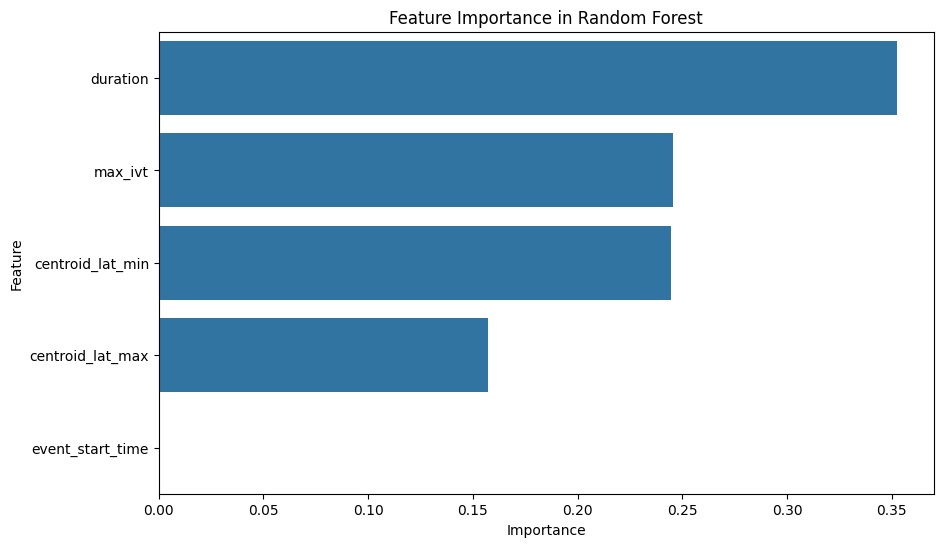

In [21]:
import seaborn as sns
# Assuming best_rf_model is your trained Random Forest model
feature_importance = best_rf_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance in Random Forest')
plt.show()

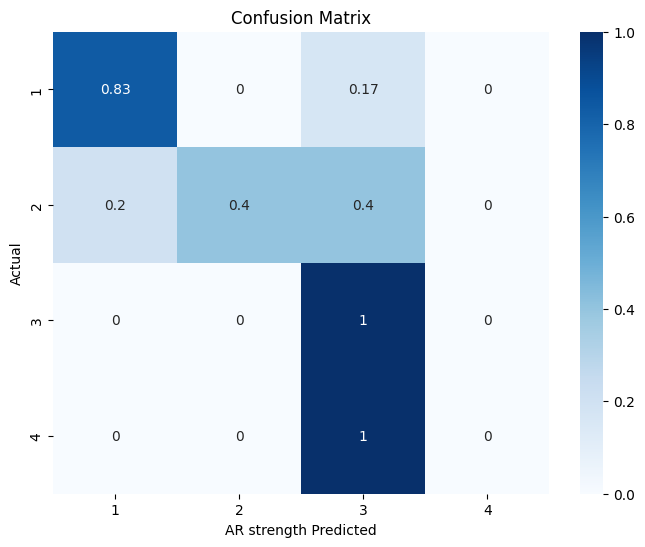

In [22]:
cm = confusion_matrix(y_val, y_pred, normalize='true')
class_labels = ['1', '2', '3', '4']
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('AR strength Predicted')
plt.ylabel('Actual')
plt.show()

In [23]:
#random forest on validation_scale with gridsearch as hyperparameter tuning

from sklearn.model_selection import GridSearchCV, StratifiedKFold

# create a random forest classifier
rf = RandomForestClassifier(random_state=42)

# define a parameter grid to search over
param_grid = {'n_estimators': [10, 50, 100, 200, 300, 400,]}

# Use stratifold k-fold cross valudation  to evaluate each combination
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# perfrom grid search
grid_search = GridSearchCV(rf, param_grid=param_grid, cv=cv, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'n_estimators': [10, 50, 100, 200, 300, 400]},
             scoring='accuracy')

In [24]:
# Get the results
best_n_estimators = grid_search.best_params_['n_estimators']
print(f'Best number of estimators: {best_n_estimators}')

# If needed, you can access other information such as the best model
best_rf_model = grid_search.best_estimator_

Best number of estimators: 10


In [25]:
# use the forest's predict method on the test data
predictions = best_rf_model.predict(X_val)
# calculate the absolute errors
predictions

array([3, 1, 2, 3, 1, 3, 3, 3, 1, 3, 2, 1, 1, 1], dtype=int64)

In [26]:
# Accuracy
accuracy = accuracy_score(y_val, predictions)
print(f'Accuracy: {accuracy}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, predictions)
print('Confusion Matrix:')
print(conf_matrix)

# Classification Report
class_report = classification_report(y_val, predictions)
print('Classification Report:')
print(class_report)

Accuracy: 0.6428571428571429
Confusion Matrix:
[[5 0 1 0]
 [1 2 2 0]
 [0 0 2 0]
 [0 0 1 0]]
Classification Report:
              precision    recall  f1-score   support

           1       0.83      0.83      0.83         6
           2       1.00      0.40      0.57         5
           3       0.33      1.00      0.50         2
           4       0.00      0.00      0.00         1

    accuracy                           0.64        14
   macro avg       0.54      0.56      0.48        14
weighted avg       0.76      0.64      0.63        14



c:\Users\Asus\miniconda3\envs\env311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Asus\miniconda3\envs\env311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Asus\miniconda3\envs\env311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


With or without GridSearch, the accuracy score remains the same. It is potentially due to small data set which result to lacking in training.

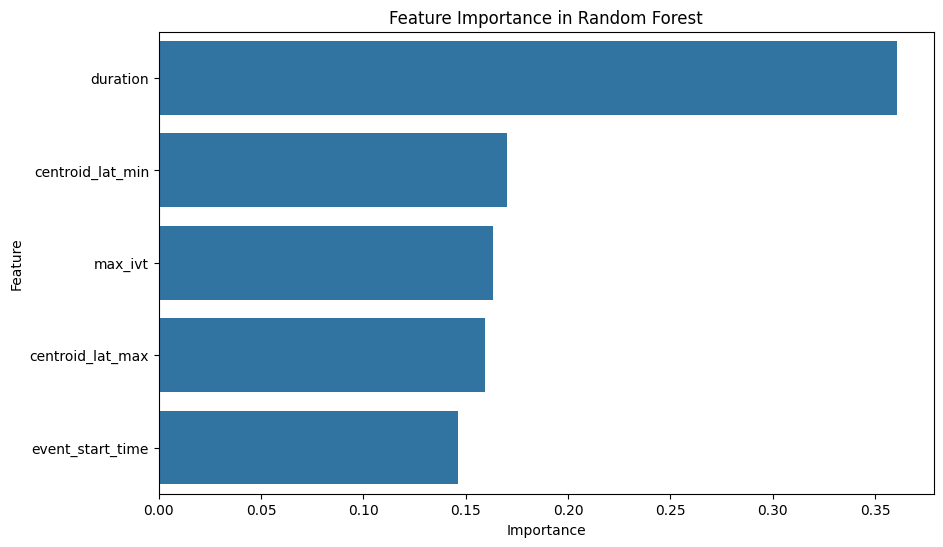

In [27]:
import seaborn as sns
# Assuming best_rf_model is your trained Random Forest model
feature_importance = best_rf_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance in Random Forest')
plt.show()

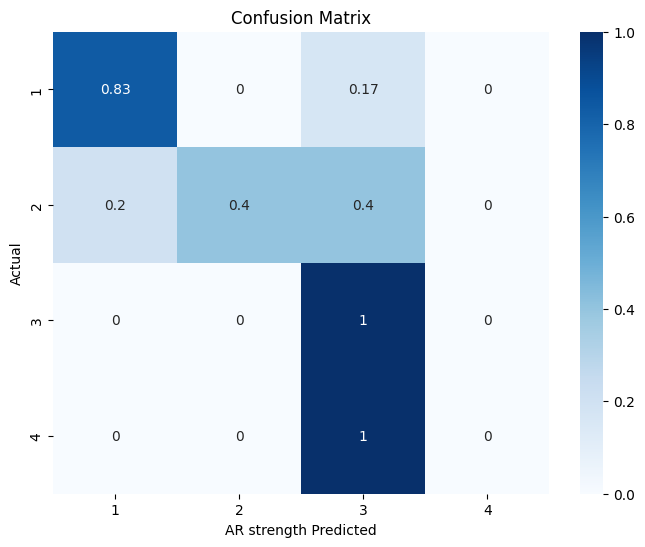

In [28]:
# Assuming y_val and y_pred are your validation set labels and predictions
cm = confusion_matrix(y_val, predictions, normalize='true')
class_labels = ['1', '2', '3', '4']
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('AR strength Predicted')
plt.ylabel('Actual')
plt.show()

**Performing Random Forest on Precipitation Type**

In [32]:
# remove area, centroid lat max, max_prcp, snow_no_snow
data = features.drop(columns=['area','max_prcp','validation_scale'], axis=1)
# Separate features and target variable
X = data.drop('snow_no_snow', axis=1)
y = data['snow_no_snow']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

In [33]:
#random forest on snow_no_snow without hyperparameter tuning
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
classification_report_output = classification_report(y_val, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report_output)


Accuracy: 0.5
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.71      0.59         7
           1       0.50      0.29      0.36         7

    accuracy                           0.50        14
   macro avg       0.50      0.50      0.48        14
weighted avg       0.50      0.50      0.48        14



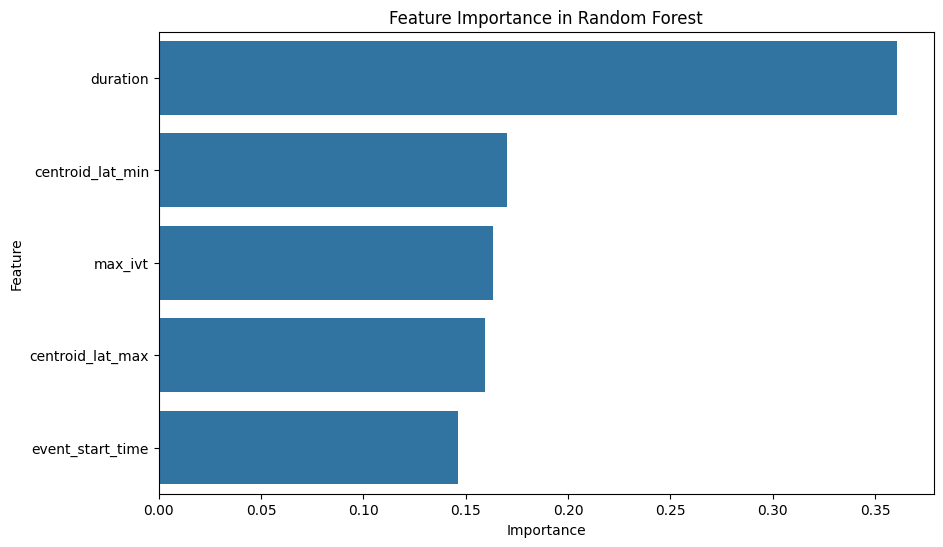

In [34]:
import seaborn as sns
# Assuming best_rf_model is your trained Random Forest model
feature_importance = best_rf_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance in Random Forest')
plt.show()

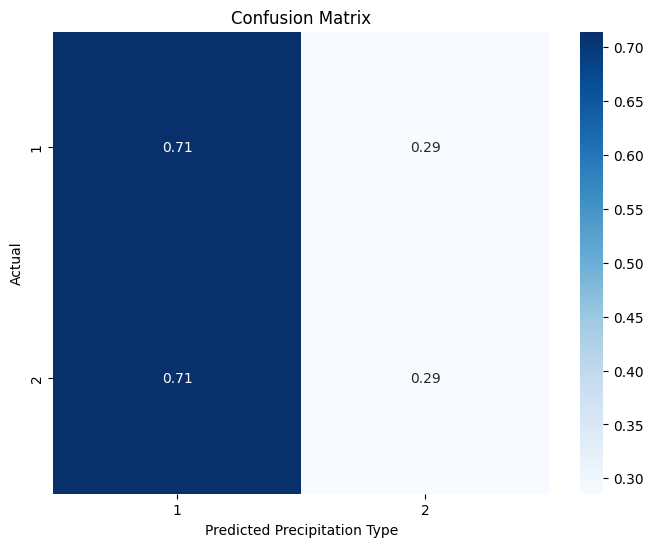

In [37]:
cm = confusion_matrix(y_val, y_pred, normalize='true')
class_labels = ['1', '2']
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Precipitation Type')
plt.ylabel('Actual')
plt.show()

In [38]:
#random forest on snow_no_snow with gridsearch as hyperparameter tuning
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# create a random forest classifier
rf = RandomForestClassifier(random_state=42)

# define a parameter grid to search over
param_grid = {'n_estimators': [10, 50, 100, 200, 300, 400,]}

# Use stratifold k-fold cross valudation  to evaluate each combination
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# perfrom grid search
grid_search = GridSearchCV(rf, param_grid=param_grid, cv=cv, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'n_estimators': [10, 50, 100, 200, 300, 400]},
             scoring='accuracy')

In [39]:
# Get the results
best_n_estimators = grid_search.best_params_['n_estimators']
print(f'Best number of estimators: {best_n_estimators}')

# If needed, you can access other information such as the best model
best_rf_model = grid_search.best_estimator_

Best number of estimators: 10


In [40]:
# use the forest's predict method on the test data
predictions = best_rf_model.predict(X_val)
# calculate the absolute errors
predictions

array([0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0], dtype=int64)

In [42]:
# Accuracy
accuracy = accuracy_score(y_val, predictions)
print(f'Accuracy: {accuracy}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, predictions)
print('Confusion Matrix:')
print(conf_matrix)

# Classification Report
class_report = classification_report(y_val, predictions)
print('Classification Report:')
print(class_report)

Accuracy: 0.5714285714285714
Confusion Matrix:
[[6 1]
 [5 2]]
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.86      0.67         7
           1       0.67      0.29      0.40         7

    accuracy                           0.57        14
   macro avg       0.61      0.57      0.53        14
weighted avg       0.61      0.57      0.53        14



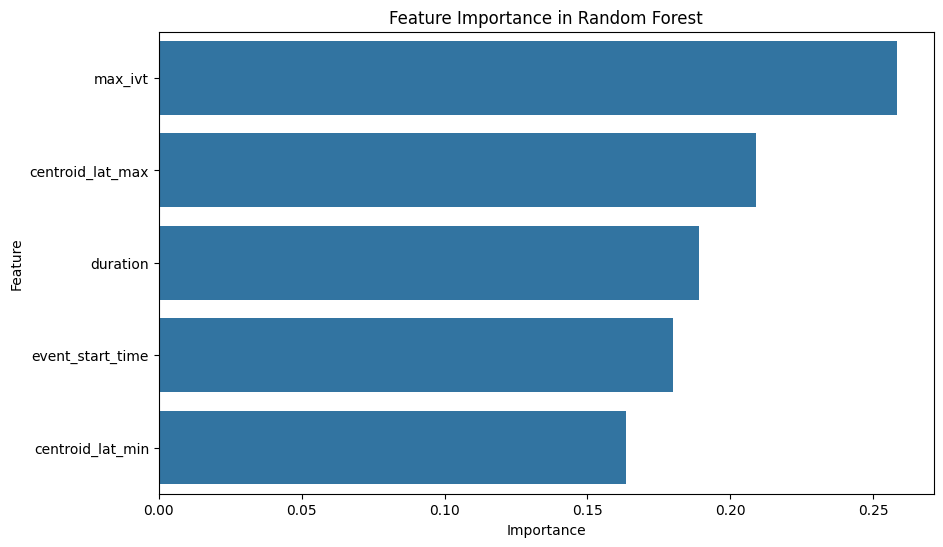

In [43]:
import seaborn as sns
# Assuming best_rf_model is your trained Random Forest model
feature_importance = best_rf_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance in Random Forest')
plt.show()

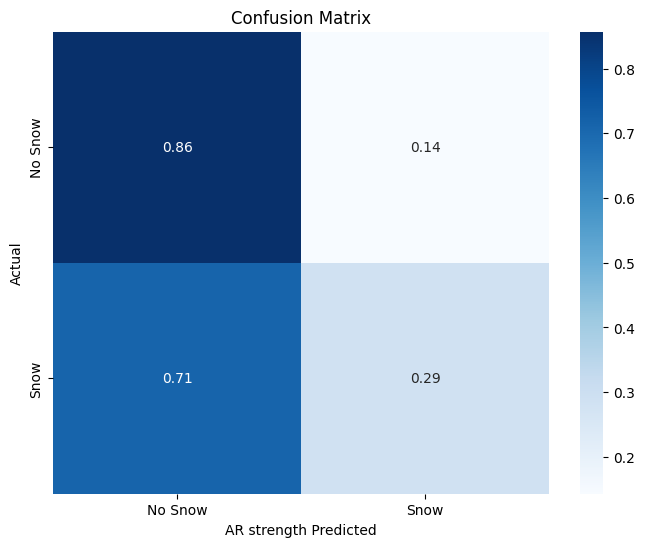

In [45]:
# Assuming y_val and y_pred are your validation set labels and predictions
cm = confusion_matrix(y_val, predictions, normalize='true')
class_labels = ['No Snow', 'Snow']
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('AR strength Predicted')
plt.ylabel('Actual')
plt.show()